In [12]:
# ================================================
# 1. IMPORT LIBRARIES
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [13]:
# load the dataset 
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

In [14]:
# quick inspect of the data
print("Rows, cols:", df.shape)
df.head()

Rows, cols: (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [15]:
# ================================================
# 3. SELECT AND CLEAN NEEDED COLUMNS
# ================================================
df = df[['age', 'sex', 'race', 'priors_count', 'two_year_recid']].copy()

# Drop missing values
df.dropna(inplace=True)

In [16]:
# ================================================
# 4. ENCODE CATEGORICAL COLUMNS
# ================================================
# Encode sex → numeric
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

# Protected attribute: race → Black (1) vs Non-Black (0)
df['protected_black'] = df['race'].apply(lambda x: 1 if x == 'African-American' else 0)

# Label: 0 = no recidivism (favorable), 1 = recidivism (unfavorable)
df['label'] = df['two_year_recid']

# Select only numeric columns AIF360 needs
final_df = df[['age', 'sex', 'priors_count', 'protected_black', 'label']]

print("Data types after cleaning:")
print(final_df.dtypes)

Data types after cleaning:
age                int64
sex                int64
priors_count       int64
protected_black    int64
label              int64
dtype: object


In [17]:
# ================================================
# 5. WRAP INTO AIF360 BinaryLabelDataset
# ================================================
bld = BinaryLabelDataset(
    df=final_df,
    label_names=['label'],
    protected_attribute_names=['protected_black'],
    favorable_label=0,
    unfavorable_label=1
)

print("\nBinaryLabelDataset successfully created!")
print("Shape:", bld.features.shape)


BinaryLabelDataset successfully created!
Shape: (7214, 4)


In [18]:
# ================================================
# 6. BIAS BEFORE MODEL
# ================================================
metric = BinaryLabelDatasetMetric(
    bld,
    privileged_groups=[{'protected_black': 0}],
    unprivileged_groups=[{'protected_black': 1}]
)

print("\n=== FAIRNESS METRICS (Before Model) ===")
print("Mean Difference:", metric.mean_difference())
print("Disparate Impact:", metric.disparate_impact())




=== FAIRNESS METRICS (Before Model) ===
Mean Difference: -0.1305990650433515
Disparate Impact: 0.7880777164102811


In [19]:
# ================================================
# 7. TRAIN A LOGISTIC REGRESSION MODEL
# ================================================
X = final_df[['age', 'sex', 'priors_count']]
y = final_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

preds = model.predict(X_test)

# Wrap test data for AIF360 comparison
test_bld = bld.subset(np.arange(len(y_test)))
test_bld_pred = test_bld.copy()
test_bld_pred.labels = preds.reshape(-1, 1)

In [20]:
# ================================================
# 8. FAIRNESS OF MODEL PREDICTIONS
# ================================================
class_metric = ClassificationMetric(
    test_bld,
    test_bld_pred,
    privileged_groups=[{'protected_black': 0}],
    unprivileged_groups=[{'protected_black': 1}]
)

print("\n=== MODEL BIAS METRICS ===")
print("False Positive Rate Difference:", class_metric.false_positive_rate_difference())
print("False Negative Rate Difference:", class_metric.false_negative_rate_difference())


=== MODEL BIAS METRICS ===
False Positive Rate Difference: 0.004641385926302144
False Negative Rate Difference: 0.0011646086595832883


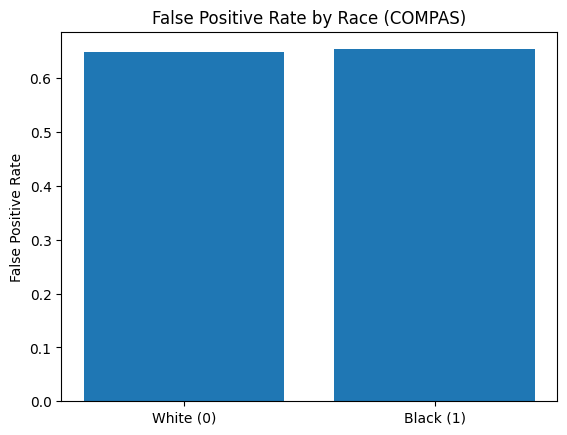

In [21]:
# ================================================
# 9. VISUALIZATION OF FPR
# ================================================
fpr_white = class_metric.false_positive_rate(privileged=True)
fpr_black = class_metric.false_positive_rate(privileged=False)

plt.bar(['White (0)', 'Black (1)'], [fpr_white, fpr_black])
plt.title("False Positive Rate by Race (COMPAS)")
plt.ylabel("False Positive Rate")
plt.show()